In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

First let's load the test results.

In [3]:
measurements = pd.read_excel('measurements.xlsx', sheet_name='measurements', header=0, index_col=0)
trials = pd.read_excel('measurements.xlsx', sheet_name='trials', header=0, index_col=0)
balls = pd.read_excel('measurements.xlsx', sheet_name='balls', header=0, index_col=0)
calibration = pd.read_excel('measurements.xlsx', sheet_name='calibration', header=0, index_col=0)

Now we merge the trials data into the measurement data.

In [4]:
merged = pd.merge(measurements, trials, how='left', left_on='trial_id', right_index=True)
merged.tail()

,trial_id,v_1,v_2,p_2,p_barometer,p_website,number_of_balls,weight_in_syringe
id,,,,,,,,
26,6,0,10,-16.1,870,86.77,0,46.87
27,6,0,10,-16.4,870,86.77,0,46.87
28,6,0,10,-16.4,870,86.77,0,46.87
29,6,0,10,-16.4,870,86.77,0,46.87
30,6,0,10,-16.5,870,86.77,0,46.87


Now we calculate displacements from the volume measurements.

In [5]:
cal_map = pd.Series(calibration['disp_mm'].values,index=calibration['vol_ml']).to_dict()
merged['d_1'] = merged['v_1'].map(cal_map)
merged['d_2'] = merged['v_2'].map(cal_map)
merged.tail()

,trial_id,v_1,v_2,p_2,p_barometer,p_website,number_of_balls,weight_in_syringe,d_1,d_2
id,,,,,,,,,,
26,6,0,10,-16.1,870,86.77,0,46.87,6.72,16.96
27,6,0,10,-16.4,870,86.77,0,46.87,6.72,16.96
28,6,0,10,-16.4,870,86.77,0,46.87,6.72,16.96
29,6,0,10,-16.4,870,86.77,0,46.87,6.72,16.96
30,6,0,10,-16.5,870,86.77,0,46.87,6.72,16.96


Next, let's convert all pressure units to kPa.

In [6]:
merged['p_2'] = merged['p_2'] * 3.38639
merged['p_barometer'] = merged['p_barometer'] * 0.1
merged.tail()

,trial_id,v_1,v_2,p_2,p_barometer,p_website,number_of_balls,weight_in_syringe,d_1,d_2
id,,,,,,,,,,
26,6,0,10,-54.520879,87.0,86.77,0,46.87,6.72,16.96
27,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96
28,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96
29,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96
30,6,0,10,-55.875435,87.0,86.77,0,46.87,6.72,16.96


We define the function for calculating volume.

In [7]:
def v1(p1, p2, dv):
    return 1. / (p1 / p2 - 1) * dv

Now let's calculate $V_1$.

In [8]:
merged['d_1_exact'] = v1(merged['p_barometer'], merged['p_barometer']+merged['p_2'], merged['d_2']-merged['d_1'])
merged.tail()

,trial_id,v_1,v_2,p_2,p_barometer,p_website,number_of_balls,weight_in_syringe,d_1,d_2,d_1_exact
id,,,,,,,,,,,
26,6,0,10,-54.520879,87.0,86.77,0,46.87,6.72,16.96,6.100162
27,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96,5.801257
28,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96,5.801257
29,6,0,10,-55.536796,87.0,86.77,0,46.87,6.72,16.96,5.801257
30,6,0,10,-55.875435,87.0,86.77,0,46.87,6.72,16.96,5.704037


Finally, we calculate the volume per ball for all trials.

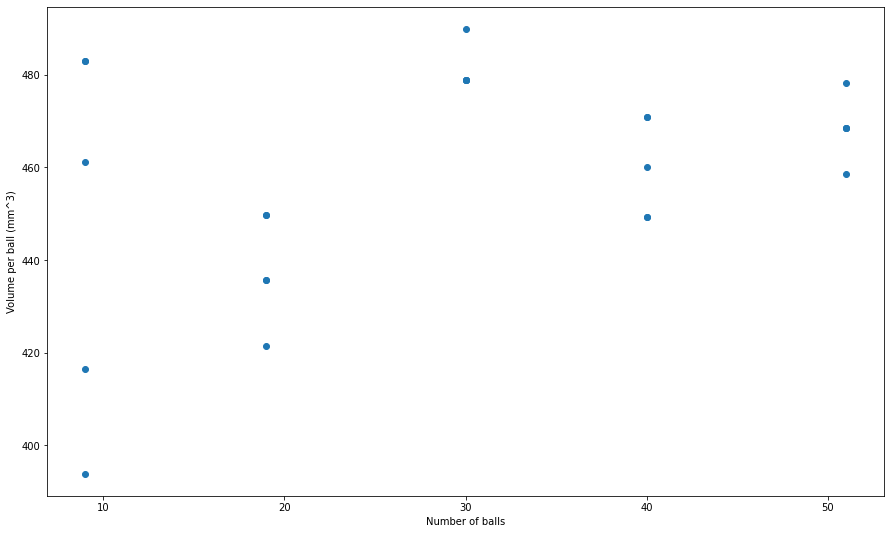

In [9]:
# Calculate empty volume of syringe
d_0 = merged[merged['number_of_balls'] == 0]['d_1_exact'].mean()

# Get adjustment to bring empty volume up to starting volume with sample
d_adj = calibration[calibration['vol_ml'] == 0]['disp_mm'].values[0]

# Calculate sample volume
merged['volume'] = (d_0 + (merged['d_1'] - d_adj) - merged['d_1_exact']) * 1000.
merged['volume_per_ball'] = merged['volume'] / merged['number_of_balls']

# Plot
fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Number of balls')
ax.set_ylabel('Volume per ball (mm^3)')

ax.scatter(merged['number_of_balls'], merged['volume_per_ball'])

Now we want to look at the error histograms for each of these points, assuming normally distributed error for pressure and volume. First we write a function to plot the histogram for a single sample.

In [43]:
def plot(empty, sample, label):
    N = 1000000
    v_error = 0.01
    p_error = 0.338639

    p_0        = np.random.normal(empty['p_barometer'], p_error, N)
    v_1_empty  = np.random.normal(empty['d_1'], v_error, N)
    v_2_empty  = np.random.normal(empty['d_2'], v_error, N)
    p_2_empty  = np.random.normal(empty['p_barometer'] + empty['p_2'], p_error, N)
    v_1_sample = np.random.normal(sample['d_1'], v_error, N)
    v_2_sample = np.random.normal(sample['d_2'], v_error, N)
    p_2_sample = np.random.normal(sample['p_barometer'] + sample['p_2'], p_error, N)

    # Get volume per ball
    v_empty = v1(p_0, p_2_empty, v_2_empty - v_1_empty)
    v_sample = v1(p_0, p_2_sample, v_2_sample - v_1_sample)
    volume = v_empty - v_1_empty + v_1_sample - v_sample
    volume_per_ball = volume / sample['number_of_balls'] * 1000.

    # Get histogram
    mean = np.mean(volume_per_ball)
    volume_error = (volume_per_ball - mean) / mean * 100.
    hist, bins = np.histogram(volume_error, bins=100, range=(-35,35))
    bins = (bins[:-1] + bins[1:]) / 2.
    
    # Choose a colour
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color = colors[int(sample['trial_id']) - 1]
    
    # Plot
    plt.plot(bins, hist, alpha=0.2, c=color, label=label)

Then we use it to plot a histogram for each result.

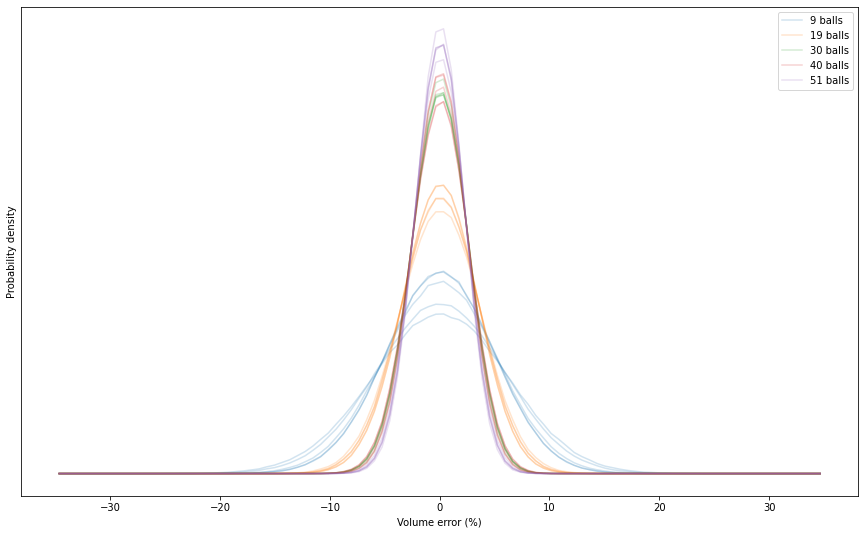

In [44]:
fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Volume error (%)')
ax.set_ylabel('Probability density')
ax.set_yticks([])

# Get first sample with 0 balls
empty = merged[merged['number_of_balls'] == 0].iloc[0]

# Keep track of which ball counts we've seen
num_balls_seen = []

# Get samples with more than 0 balls
samples = merged[merged['number_of_balls'] > 0]
for index, row in samples.iterrows():
    num_balls = int(row['number_of_balls'])
    if num_balls in num_balls_seen:
        label = None
    else:
        label = f'{num_balls} balls'
        num_balls_seen.append(num_balls)
    
    plot(empty, row, label)

ax.legend()

This is the *random error* in the result--i.e., the error due to random variation in the raw measurements. There is another kind of error, called *systematic error* which is not accounted for here. For example, a consistent offset in pressure due to inaccuracy in the pressure gauge would be a systematic error.

The nice thing about these systematic errors is that we can usually calibrate them out. For example, if we have an offset in the pressure readings, then we can use a calibration sample (e.g., steel shot) to work out how much the pressure measurements need to be shifted to get an accurate result.